Привет, меня зовут Андрей Александров.  
К сожалению, я успел сделать очень мало (только посмотрел данные и прогнал на них ненастроенные модели), но при этом за разумное дополнительное время я не успею ничего сделать.  
Так как команда работала над тем, чтобы организовать этот проект, поддерживать и помогать нам над проектом, то я считаю, что нужно все равно отправить проект на проверку, чтобы было понятно, что они нужны и работа не впустую, хотя и сделано меньше чем ожидалось :)  
Спасибо за интересный проект :)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/used-cars-price-prediction-22ds/sample_submission.csv
/kaggle/input/used-cars-price-prediction-22ds/train.csv
/kaggle/input/used-cars-price-prediction-22ds/test.csv


In [2]:
! pip install vininfo

In [3]:
! pip install pyvin

In [4]:
import missingno as msno
import seaborn as sns
from vininfo import Vin
from pyvin import VIN
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.compose import make_column_transformer
from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_absolute_percentage_error
from IPython.display import HTML
import pandas as pd
import numpy as np
import xgboost as xgb


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
# создадим функцию для создания ссылки на файл с результатами

def create_download_link(title = "Download CSV file", filename = "data.csv"):  
    html = '<a href={filename}>{title}</a>'
    html = html.format(title=title,filename=filename)
    return HTML(html)

# Загрузим данные

## Тренировочные данные

In [6]:
# загрузим тренировочные данные
train_df = pd.read_csv('/kaggle/input/used-cars-price-prediction-22ds/train.csv')

In [7]:
# создадим функцию для первичного просмотра данных
def first_look(df):
    display(df.head())
    print(df.info())
    display(df.describe())

In [8]:
first_look(train_df)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate
0,2011,Ford,Edge,SEL,suv,automatic,2fmdk3jc4bba41556,md,4.2,111041.0,black,black,santander consumer,12500,Tue Jun 02 2015 02:30:00 GMT-0700 (PDT)
1,2014,Ford,Fusion,SE,Sedan,automatic,3fa6p0h75er208976,mo,3.5,31034.0,black,black,ars/avis budget group,14500,Wed Feb 25 2015 02:00:00 GMT-0800 (PST)
2,2012,Nissan,Sentra,2.0 SL,sedan,automatic,3n1ab6ap4cl698412,nj,2.2,35619.0,black,black,nissan-infiniti lt,9100,Wed Jun 10 2015 02:30:00 GMT-0700 (PDT)
3,2003,HUMMER,H2,Base,suv,automatic,5grgn23u93h101360,tx,2.8,131301.0,gold,beige,wichita falls ford lin inc,13300,Wed Jun 17 2015 03:00:00 GMT-0700 (PDT)
4,2007,Ford,Fusion,SEL,Sedan,automatic,3fahp08z17r268380,md,2.0,127709.0,black,black,purple heart,1300,Tue Feb 03 2015 04:00:00 GMT-0800 (PST)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440236 entries, 0 to 440235
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          440236 non-null  int64  
 1   make          432193 non-null  object 
 2   model         432113 non-null  object 
 3   trim          431899 non-null  object 
 4   body          429843 non-null  object 
 5   transmission  388775 non-null  object 
 6   vin           440236 non-null  object 
 7   state         440236 non-null  object 
 8   condition     430831 non-null  float64
 9   odometer      440167 non-null  float64
 10  color         439650 non-null  object 
 11  interior      439650 non-null  object 
 12  seller        440236 non-null  object 
 13  sellingprice  440236 non-null  int64  
 14  saledate      440236 non-null  object 
dtypes: float64(2), int64(2), object(11)
memory usage: 50.4+ MB
None


,year,condition,odometer,sellingprice
count,440236.000000,430831.000000,440167.000000,440236.000000
mean,2010.040101,3.425077,68344.421604,13592.209588
std,3.977945,0.949973,53542.203908,9751.479098
min,1982.000000,1.000000,1.000000,1.000000
25%,2007.000000,2.700000,28258.000000,6900.000000
50%,2012.000000,3.600000,52098.000000,12100.000000
75%,2013.000000,4.200000,99272.000000,18200.000000
max,2015.000000,5.000000,999999.000000,230000.000000


* Потребуется преобразовать столбец saledate к datetime, разобраться со столбцом state, придумать как обработать vin номер
* В данных присутствуют пропуски
* В наших данных машины:
    + от 1982 до 2015 года выпуска
    + с пробегом от 1 до 999999
    + по цене от 1 до 230000

## Тестовые данные

In [9]:
test_df = pd.read_csv('/kaggle/input/used-cars-price-prediction-22ds/test.csv')

In [10]:
first_look(test_df)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,saledate
0,2005,Cadillac,CTS,Base,Sedan,automatic,1g6dp567450124779,ca,2.7,116970.0,silver,black,lexus of stevens creek,Wed Jan 14 2015 04:30:00 GMT-0800 (PST)
1,2014,GMC,Savana Cargo,2500,Van,NaN,1gtw7fca7e1902207,pa,4.4,6286.0,white,gray,u-haul,Fri Feb 27 2015 01:00:00 GMT-0800 (PST)
2,2013,Nissan,Murano,S,SUV,automatic,jn8az1mw6dw303497,oh,4.6,11831.0,gray,black,nissan-infiniti lt,Tue Feb 24 2015 01:30:00 GMT-0800 (PST)
3,2013,Chevrolet,Impala,LS Fleet,Sedan,automatic,2g1wf5e34d1160703,fl,2.3,57105.0,silver,black,onemain rem/auto club of miami inc dba north dad,Fri Mar 06 2015 02:00:00 GMT-0800 (PST)
4,2013,Nissan,Titan,SV,Crew Cab,automatic,1n6aa0ec3dn301209,tn,2.9,31083.0,black,black,nissan north america inc.,Wed Jun 03 2015 03:30:00 GMT-0700 (PDT)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110058 entries, 0 to 110057
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          110058 non-null  int64  
 1   make          107997 non-null  object 
 2   model         107979 non-null  object 
 3   trim          107944 non-null  object 
 4   body          107464 non-null  object 
 5   transmission  97047 non-null   object 
 6   vin           110058 non-null  object 
 7   state         110058 non-null  object 
 8   condition     107679 non-null  float64
 9   odometer      110039 non-null  float64
 10  color         109900 non-null  object 
 11  interior      109900 non-null  object 
 12  seller        110058 non-null  object 
 13  saledate      110058 non-null  object 
dtypes: float64(2), int64(1), object(11)
memory usage: 11.8+ MB
None


,year,condition,odometer
count,110058.000000,107679.000000,110039.000000
mean,2010.060005,3.423222,68074.331601
std,3.960190,0.951301,53520.988173
min,1982.000000,1.000000,1.000000
25%,2007.000000,2.700000,28313.500000
50%,2012.000000,3.600000,51922.000000
75%,2013.000000,4.200000,98852.500000
max,2015.000000,5.000000,999999.000000


* В тестовых данных присутствуют пропуски

# Пробный CatBoostRegressor на необработанных данных
который будем использовать, как отправную точку

In [11]:
# строки с пропущенными численными значениями заполним средними значениями по этим данным
train_df_for_raw_cat_boost = train_df.copy()
train_df_for_raw_cat_boost['odometer'] = train_df_for_raw_cat_boost['odometer'].fillna(train_df_for_raw_cat_boost['odometer'].mean())
train_df_for_raw_cat_boost['condition'] = train_df_for_raw_cat_boost['condition'].fillna(train_df_for_raw_cat_boost['condition'].mean())

# оставшиеся пропуски заполним значением 'unknown'
train_df_for_raw_cat_boost = train_df_for_raw_cat_boost.fillna('unknown')

# удалим признаки, которые не должны влиять
X_for_raw_cat_boost = train_df_for_raw_cat_boost.drop(['vin', 'saledate', 'sellingprice'], axis=1)
y_for_raw_cat_boost = train_df_for_raw_cat_boost['sellingprice']

# создадим список категориальных признаков
cat_features_pure = ['make', 'model', 'trim', 'body', 'transmission', 'state', 'color', 'interior', 'seller']

In [13]:
# создадим и обучим CatBoostRegressor
cbr_on_raw_data = CatBoostRegressor(cat_features=cat_features_pure,
                       loss_function='MAPE',
                       logging_level='Silent')
cbr_on_raw_data.fit(X_for_raw_cat_boost, y_for_raw_cat_boost)
cbr_on_raw_data.get_best_score

<bound method _CatBoostBase.get_best_score of <catboost.core.CatBoostRegressor object at 0x7f9f149ba830>>

In [14]:
# опробуем на тестовых данных
test_df_for_raw_cat_boost = test_df.copy()
test_df_for_raw_cat_boost['odometer'] = test_df_for_raw_cat_boost['odometer'].fillna(test_df_for_raw_cat_boost['odometer'].mean())
test_df_for_raw_cat_boost['condition'] = test_df_for_raw_cat_boost['condition'].fillna(test_df_for_raw_cat_boost['condition'].mean())
test_df_for_raw_cat_boost = test_df_for_raw_cat_boost.fillna('unknown')

X_test_raw_data = test_df_for_raw_cat_boost.drop(['vin', 'saledate'], axis=1)

preds_test = cbr_on_raw_data.predict(X_test_raw_data)
submission_cbr_raw_data = pd.DataFrame(data=preds_test, index=test_df_for_raw_cat_boost['vin'])
submission_cbr_raw_data = submission_cbr_raw_data.rename(columns={0: "sellingprice"})

submission_cbr_raw_data.to_csv('submission_cbr_raw_data.csv')
# create a link to download the dataframe which was saved with .to_csv method
create_download_link(filename='submission_cbr_raw_data.csv')

## Результат на Kaggle: MAPE = 51.66309

# Проведем исследовательский анализ данных

In [15]:
# преобразуем столбец saledate
train_df['saledate'] = pd.to_datetime(train_df['saledate'])

In [16]:
# проверим наличие дубликатов
train_df.duplicated().sum()

0

Полных дубликатов нет

In [17]:
# проверим наличие дубликатов по столбцу vin
train_df.duplicated('vin').sum()

0

Дубликатов нет

In [18]:
# проверим наличие пропусков
train_df.isnull().sum()

year                0
make             8043
model            8123
trim             8337
body            10393
transmission    51461
vin                 0
state               0
condition        9405
odometer           69
color             586
interior          586
seller              0
sellingprice        0
saledate            0
dtype: int64

In [19]:
# пропуски в процентном отношении
train_df.isnull().sum()/ len(train_df)* 100

year             0.000000
make             1.826975
model            1.845147
trim             1.893757
body             2.360779
transmission    11.689412
vin              0.000000
state            0.000000
condition        2.136354
odometer         0.015673
color            0.133110
interior         0.133110
seller           0.000000
sellingprice     0.000000
saledate         0.000000
dtype: float64

In [20]:
sns.set;

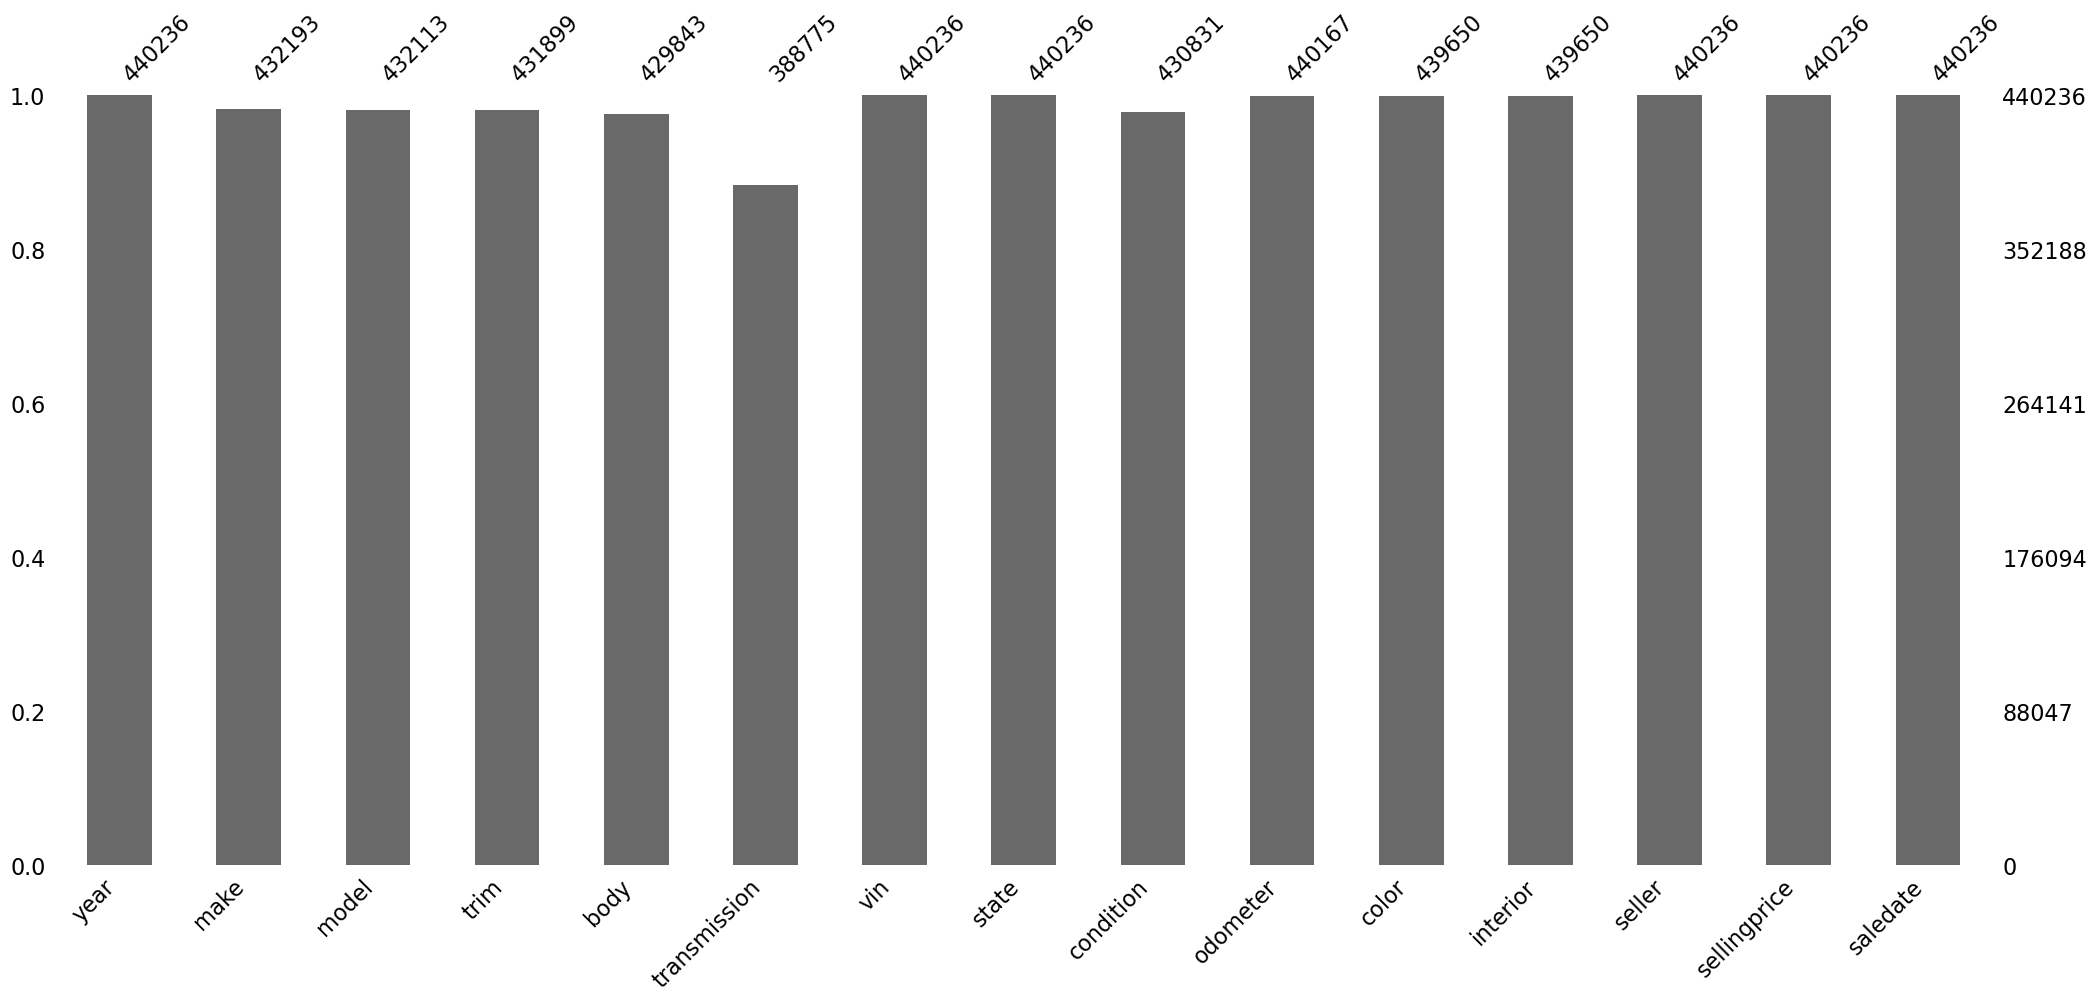

In [21]:
# посмотрим на заполненность данных
msno.bar(train_df);

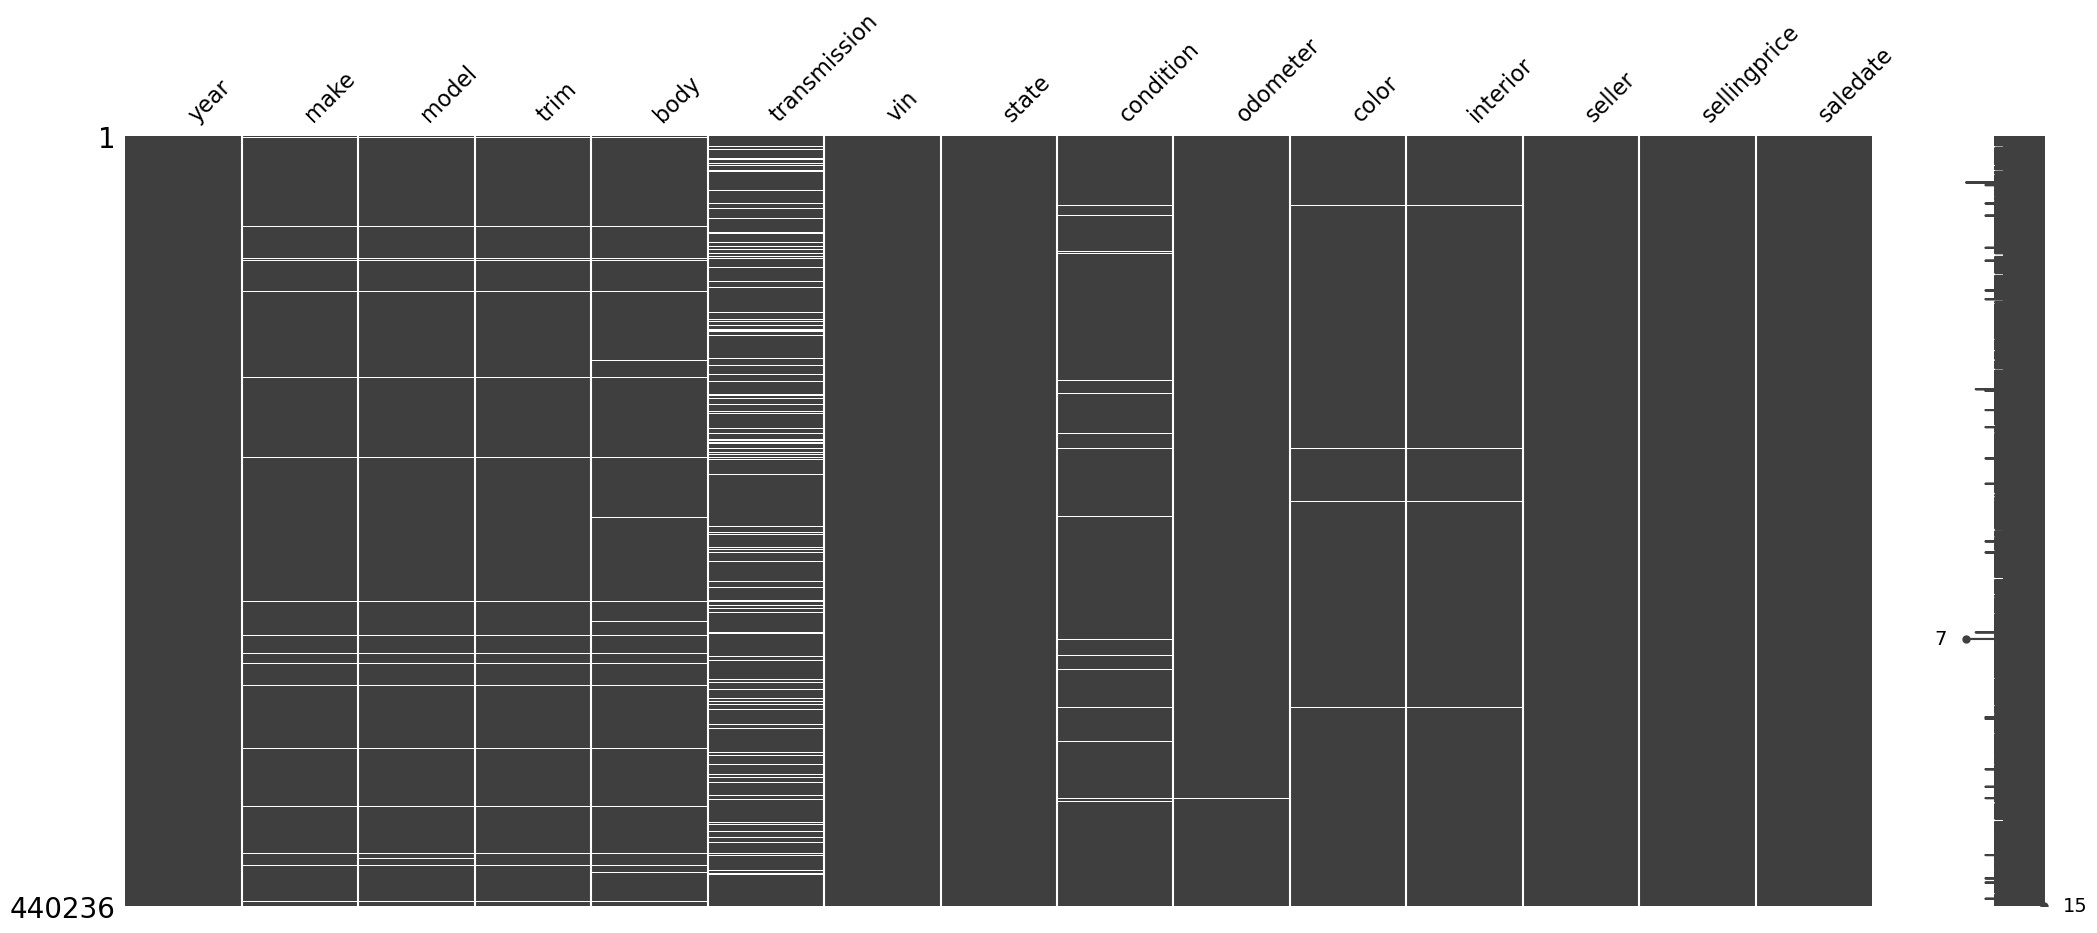

In [22]:
msno.matrix(train_df);

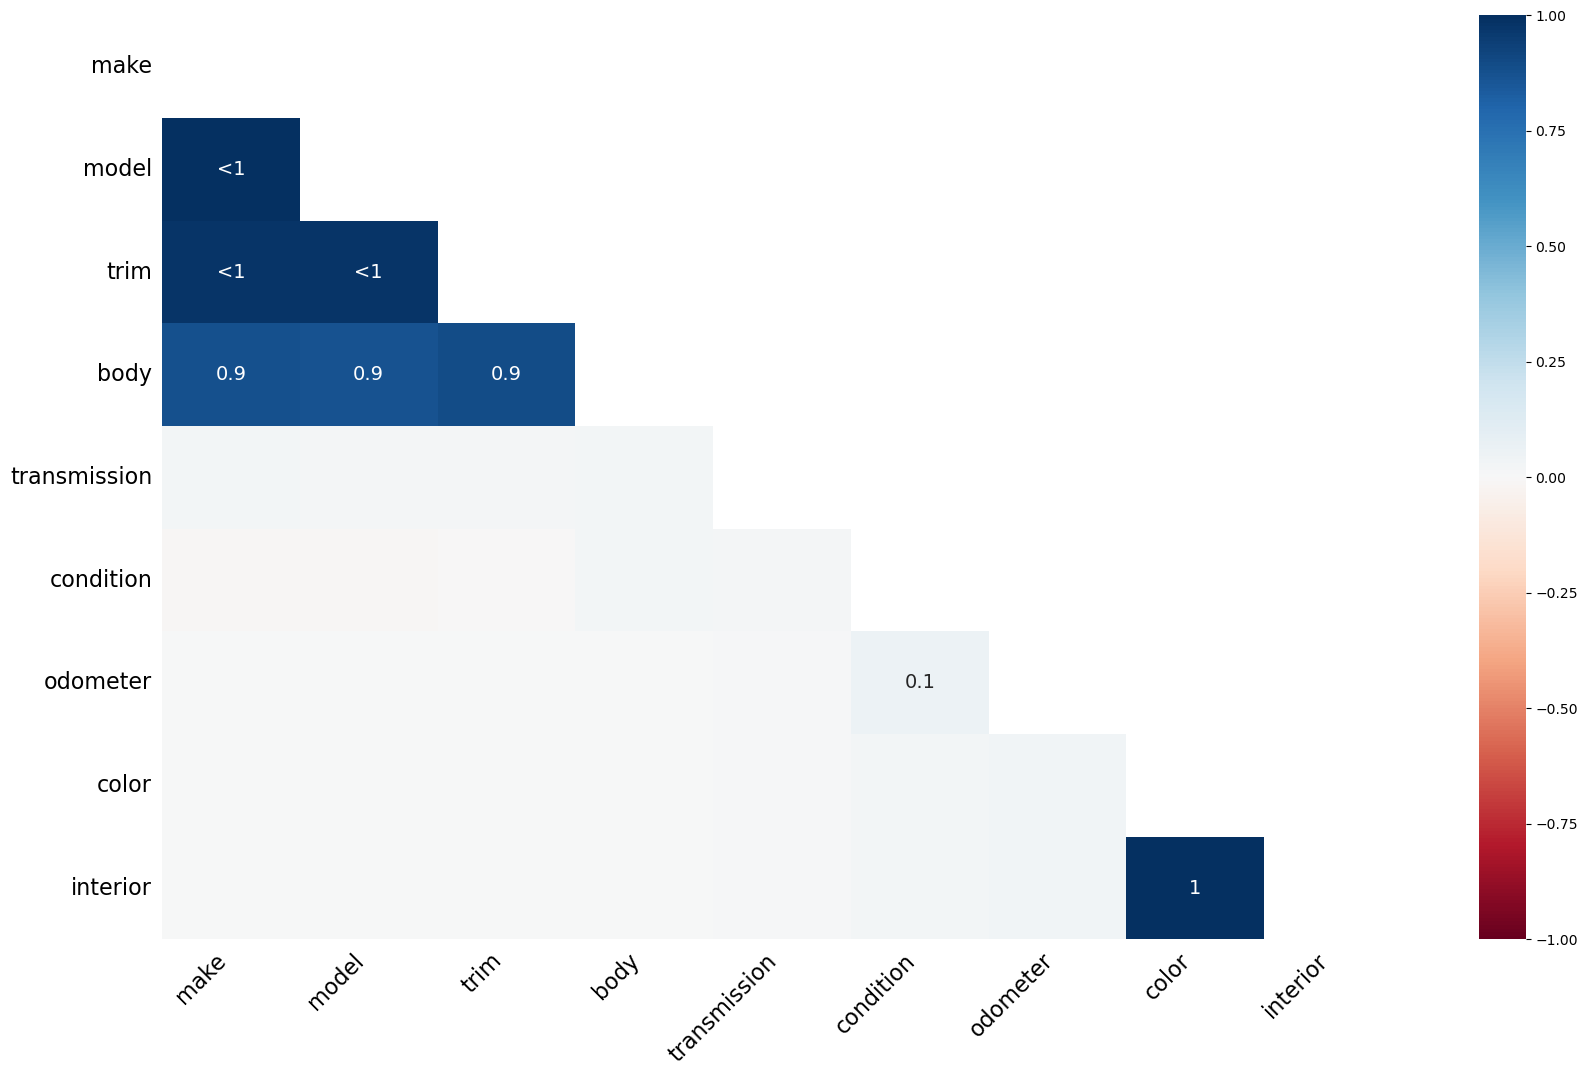

In [23]:
msno.heatmap(train_df);

Из тепловой карты видно, что большинство пропусков отсутствуют в одних объявлениях

In [24]:
# посмотрим на пропуски
train_df[train_df.isna().any(axis=1)].head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate
6,2010,pontiac,g6,4c,NaN,automatic,1g2za5eb4a4157380,nc,3.4,114587.0,silver,black,north state acceptance,5900,2015-01-12 09:30:00+08:00
10,2007,NaN,NaN,NaN,NaN,automatic,5tfbv54157x019560,ca,3.1,102507.0,blue,gray,aaero sweet company,17250,2015-01-29 03:30:00+08:00
13,2006,Chevrolet,Silverado 1500,LS,Extended Cab,NaN,1gcek19bx6z269153,tx,2.2,166999.0,white,gray,texas direct auto,6700,2015-02-25 02:20:00+08:00
27,2014,Dodge,Charger,SXT,Sedan,NaN,2c3cdxhg0eh267271,va,4.0,21631.0,blue,black,hertz corporation/gdp,18100,2015-02-12 00:45:00+08:00
31,2012,Mercedes-Benz,GL-Class,GL450 4MATIC,SUV,NaN,4jgbf7be8ca797360,ga,4.1,55612.0,white,brown,mercedes-benz finc wholesale advantage,30750,2015-02-04 02:00:00+08:00


In [25]:
# посмотрим записи, где есть указания изготовителя, но пропущены названия модели
train_df.loc[train_df['make'].notna() & train_df['model'].isna()]

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate
133,2014,BMW,NaN,750Li,Sedan,automatic,wbaye8c58eds16086,ca,4.7,14886.0,gray,black,financial services remarketing (lease),93000,2015-05-21 05:30:00+07:00
14018,2014,BMW,NaN,750Li xDrive,Sedan,automatic,wbayf8c50ed142661,oh,3.7,19926.0,white,tan,bmw na manheim new jersey,60500,2014-12-30 14:00:00+08:00
16652,2015,BMW,NaN,650i xDrive,sedan,automatic,wba6b4c59fd761465,nj,5.0,2496.0,gray,black,bmw na manheim new jersey,78500,2015-06-02 07:00:00+07:00
17508,2015,Audi,NaN,2.0 TFSI Premium quattro,sedan,automatic,waubfgff6f1002038,ca,5.0,7652.0,white,black,vw credit,25000,2015-06-18 05:30:00+07:00
21917,2015,BMW,NaN,750i xDrive,Sedan,automatic,wbayb6c50fd965768,nj,4.8,5864.0,—,tan,bmw na manheim new jersey,77000,2015-06-02 07:00:00+07:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413950,2014,BMW,NaN,750Li xDrive,Sedan,automatic,wbayf8c57ed142513,nj,4.9,2693.0,white,—,bmw na manheim new jersey,79000,2015-02-10 06:00:00+08:00
421169,2014,BMW,NaN,750Li,Sedan,automatic,wbaye8c55ed780701,nj,5.0,2423.0,black,black,bmw na manheim new jersey,70000,2015-01-13 06:00:00+08:00
425756,2014,BMW,NaN,750Li xDrive,Sedan,automatic,wbayf8c55ed652522,nj,4.9,1478.0,white,black,bmw na manheim new jersey,75500,2015-02-10 06:00:00+08:00
427034,2015,Audi,NaN,2.0 TFSI Premium quattro,Sedan,automatic,waubfgff3f1001199,ca,4.1,7287.0,black,black,vci/auto gallery,26750,2015-02-26 04:30:00+08:00


У многих BMW пропущена модель, но при этом модель можно узнать из названия комплектации автомобиля

In [26]:
# из комплектации возьмем модель и припишем Series
train_df.loc[(train_df['make'] == 'BMW') & (train_df['model'].isna()), 'model'] = \
    train_df["trim"].astype(str).map(lambda x: x[:1]) + " Series"

In [27]:
# посмотрим на список моделей, которые получились для проверки адекватности
train_df.loc[(train_df['make'] == 'BMW')].groupby(['model']).count()

,year,make,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate
model,,,,,,,,,,,,,,
1 Series,312,312,312,312,284,312,312,311,312,311,311,312,312,312
2 Series,23,23,23,23,23,23,23,23,23,23,23,23,23,23
3 Series,6406,6406,6406,6406,5694,6406,6406,6262,6406,6392,6392,6406,6406,6406
3 Series Gran Turismo,58,58,58,58,56,58,58,58,58,58,58,58,58,58
4 Series,247,247,247,247,238,247,247,247,247,241,241,247,247,247
4 Series Gran Coupe,11,11,11,11,11,11,11,11,11,10,10,11,11,11
5 Series,3264,3264,3264,3264,2788,3264,3264,3199,3264,3253,3253,3264,3264,3264
5 Series Gran Turismo,157,157,157,157,131,157,157,155,157,154,154,157,157,157
6 Series,530,530,530,530,480,530,530,524,530,521,521,530,530,530


In [28]:
# посмотрим записи, где есть указания изготовителя, но пропущены названия модели
display(train_df.loc[train_df['make'].notna() & train_df['model'].isna()])
print('Количество пропусков в моделях, когда известен производитель')
len(train_df.loc[train_df['make'].notna() & train_df['model'].isna()])

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate
17508,2015,Audi,NaN,2.0 TFSI Premium quattro,sedan,automatic,waubfgff6f1002038,ca,5.0,7652.0,white,black,vw credit,25000,2015-06-18 05:30:00+07:00
183518,2015,Audi,NaN,2.0 TFSI Premium quattro,sedan,NaN,waubfgff0f1007039,pa,4.9,8109.0,gray,black,manheim imports,26900,2015-05-28 02:30:00+07:00
230018,2015,Audi,NaN,2.0 TFSI Premium quattro,Sedan,automatic,waubfgff1f1001122,ca,4.6,8996.0,black,beige,vci/auto gallery,27000,2015-02-26 04:30:00+08:00
239974,2015,Audi,NaN,2.0 TFSI Premium quattro,Sedan,NaN,waubfgffxf1002043,pa,4.1,4299.0,black,black,audi of huntington,28000,2015-05-22 02:00:00+07:00
286216,2015,Audi,NaN,2.0 TFSI Premium quattro,Sedan,automatic,waubfgff3f1002269,ca,4.8,9070.0,gray,black,vci/auto gallery,27000,2015-02-26 04:30:00+08:00
326034,2015,Audi,NaN,2.0 TFSI Premium quattro,Sedan,automatic,waubfgff3f1005561,fl,4.7,5767.0,white,black,vw credit,25200,2015-01-21 01:30:00+08:00
358186,2015,Audi,NaN,2.0 TFSI Premium quattro,sedan,automatic,waubfgffxf1005315,tx,3.5,4529.0,gray,black,tdaf remarketing,27000,2015-06-17 03:15:00+07:00
359873,2015,Audi,NaN,2.0 TFSI Premium quattro,Sedan,automatic,waubfgff5f1000653,wa,4.8,7960.0,black,black,vw credit xu ready,27600,2015-02-18 04:30:00+08:00
408232,2015,Audi,NaN,2.0 TFSI Premium quattro,Sedan,NaN,waubfgff7f1009810,pa,4.5,3954.0,gray,black,bard whls,27500,2015-02-06 01:00:00+08:00
427034,2015,Audi,NaN,2.0 TFSI Premium quattro,Sedan,automatic,waubfgff3f1001199,ca,4.1,7287.0,black,black,vci/auto gallery,26750,2015-02-26 04:30:00+08:00


Количество пропусков в моделях, когда известен производитель


10

В PyVIN и Vininfo нехватает данных для использования, не позволяют заполнить данные

In [29]:
print(Vin(train_df['vin'][1]).details)

None


In [30]:
VIN(train_df['vin'][2])

[]

## Пока что заполним все пропуски в численных данных средними значениями, а в категориальных значением 'unknown'

In [31]:
# проверим наличие пропусков
train_df.isnull().sum()

year                0
make             8043
model            8053
trim             8337
body            10393
transmission    51461
vin                 0
state               0
condition        9405
odometer           69
color             586
interior          586
seller              0
sellingprice        0
saledate            0
dtype: int64

In [32]:
# создадим функцию для заполнения пропусков
def my_fillna(df):
    df['odometer'] = df['odometer'].fillna(df['odometer'].mean())
    df['condition'] = df['condition'].fillna(df['condition'].mean())
    
    return df.fillna('unknown')

In [33]:
train_df_filled = my_fillna(train_df)

In [34]:
train_df_filled.isnull().sum()

year            0
make            0
model           0
trim            0
body            0
transmission    0
vin             0
state           0
condition       0
odometer        0
color           0
interior        0
seller          0
sellingprice    0
saledate        0
dtype: int64

In [35]:
# выделим категориальные признаки
cat_features = ['make', 'model', 'trim', 'body', 'transmission', 'state', 'color', 'interior', 'seller']

## Посмотрим уникальные значения категориальных признаков

In [36]:
train_df_filled['make'].unique()

array(['Ford', 'Nissan', 'HUMMER', 'Lincoln', 'pontiac', 'Hyundai',
       'unknown', 'Buick', 'Chevrolet', 'Honda', 'Acura', 'Cadillac',
       'GMC', 'Saab', 'Dodge', 'Mercedes-Benz', 'Toyota', 'Volkswagen',
       'BMW', 'Infiniti', 'Chrysler', 'Kia', 'Jaguar', 'Subaru', 'Jeep',
       'Lexus', 'mercedes', 'Scion', 'FIAT', 'Suzuki', 'Mazda', 'Volvo',
       'Audi', 'MINI', 'Isuzu', 'Mitsubishi', 'smart', 'Pontiac',
       'Porsche', 'subaru', 'ford', 'Land Rover', 'chrysler', 'Saturn',
       'mazda', 'dodge', 'Ram', 'Oldsmobile', 'hyundai', 'Mercury',
       'Bentley', 'toyota', 'lincoln', 'Fisker', 'nissan', 'chevrolet',
       'honda', 'porsche', 'mitsubishi', 'lexus', 'bmw', 'Maserati',
       'acura', 'jeep', 'mercury', 'Tesla', 'landrover', 'vw', 'cadillac',
       'buick', 'gmc truck', 'land rover', 'volkswagen', 'Rolls-Royce',
       'audi', 'Ferrari', 'suzuki', 'Plymouth', 'oldsmobile',
       'Lamborghini', 'gmc', 'Geo', 'ford truck', 'Aston Martin',
       'plymouth', 'Da

In [37]:
# переведем все категориальные признаки к нижнему регистру
for feature in cat_features:
    train_df_filled[feature] = train_df_filled[feature].str.lower()

In [38]:
# посмотрим на результат
train_df_filled['make'].unique()

array(['ford', 'nissan', 'hummer', 'lincoln', 'pontiac', 'hyundai',
       'unknown', 'buick', 'chevrolet', 'honda', 'acura', 'cadillac',
       'gmc', 'saab', 'dodge', 'mercedes-benz', 'toyota', 'volkswagen',
       'bmw', 'infiniti', 'chrysler', 'kia', 'jaguar', 'subaru', 'jeep',
       'lexus', 'mercedes', 'scion', 'fiat', 'suzuki', 'mazda', 'volvo',
       'audi', 'mini', 'isuzu', 'mitsubishi', 'smart', 'porsche',
       'land rover', 'saturn', 'ram', 'oldsmobile', 'mercury', 'bentley',
       'fisker', 'maserati', 'tesla', 'landrover', 'vw', 'gmc truck',
       'rolls-royce', 'ferrari', 'plymouth', 'lamborghini', 'geo',
       'ford truck', 'aston martin', 'daewoo', 'mercedes-b', 'dodge tk',
       'mazda tk', 'dot', 'airstream'], dtype=object)

In [39]:
# создадим функцию, приводящую названия к единому стилю
def make_unique(df):
    df['make'] = df['make'].replace({'mercedes': 'mercedes-benz', 'mercedes-b': 'mercedes', 'vw': 'volkswagen', 
                                     'gmc truck': 'gmc', 'ford truck': 'ford', 'dodge tk': 'dodge', 'mazda tk': 'mazda'})

In [40]:
make_unique(train_df_filled)

In [41]:
# посмотрим на результат
train_df_filled['make'].unique()

array(['ford', 'nissan', 'hummer', 'lincoln', 'pontiac', 'hyundai',
       'unknown', 'buick', 'chevrolet', 'honda', 'acura', 'cadillac',
       'gmc', 'saab', 'dodge', 'mercedes-benz', 'toyota', 'volkswagen',
       'bmw', 'infiniti', 'chrysler', 'kia', 'jaguar', 'subaru', 'jeep',
       'lexus', 'scion', 'fiat', 'suzuki', 'mazda', 'volvo', 'audi',
       'mini', 'isuzu', 'mitsubishi', 'smart', 'porsche', 'land rover',
       'saturn', 'ram', 'oldsmobile', 'mercury', 'bentley', 'fisker',
       'maserati', 'tesla', 'landrover', 'rolls-royce', 'ferrari',
       'plymouth', 'lamborghini', 'geo', 'aston martin', 'daewoo',
       'mercedes', 'dot', 'airstream'], dtype=object)

# Разделим на признаки и цели

In [42]:
X = train_df_filled.drop(['vin', 'sellingprice', 'saledate'], axis=1)
y = train_df_filled['sellingprice']

# Преобразуем признаки, используя OrdinalEncoder

In [43]:
X_oe=X.copy()

In [44]:
oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_oe[cat_features] = oe.fit_transform(X_oe[cat_features])

In [45]:
X_oe.head()

,year,make,model,trim,body,transmission,state,condition,odometer,color,interior,seller
0,2011,16.0,242.0,1410.0,39.0,0.0,12.0,4.2,111041.0,1.0,1.0,10697.0
1,2014,16.0,321.0,1379.0,36.0,0.0,15.0,3.5,31034.0,1.0,1.0,736.0
2,2012,39.0,667.0,69.0,36.0,0.0,19.0,2.2,35619.0,1.0,1.0,8503.0
3,2003,20.0,383.0,581.0,39.0,0.0,33.0,2.8,131301.0,6.0,0.0,12845.0
4,2007,16.0,321.0,1410.0,36.0,0.0,12.0,2.0,127709.0,1.0,1.0,9750.0


In [46]:
X_oe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440236 entries, 0 to 440235
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          440236 non-null  int64  
 1   make          440236 non-null  float64
 2   model         440236 non-null  float64
 3   trim          440236 non-null  float64
 4   body          440236 non-null  float64
 5   transmission  440236 non-null  float64
 6   state         440236 non-null  float64
 7   condition     440236 non-null  float64
 8   odometer      440236 non-null  float64
 9   color         440236 non-null  float64
 10  interior      440236 non-null  float64
 11  seller        440236 non-null  float64
dtypes: float64(11), int64(1)
memory usage: 40.3 MB


# DecisionTreeRegressor на данных после OrdinalEncoding

In [47]:
%%time
dtr = DecisionTreeRegressor(random_state=0)
params = {}
gscv_dtr = GridSearchCV(dtr, params, scoring='neg_mean_absolute_percentage_error')
gscv_dtr.fit(X_oe, y)
print(f'Best_score = {gscv_dtr.best_score_}')
print(f'MAPE = {mean_absolute_percentage_error(y, gscv_dtr.predict(X_oe))}')

Best_score = -0.2481683888590668
MAPE = 0.0
CPU times: user 28.4 s, sys: 479 ms, total: 28.9 s
Wall time: 28.9 s


In [48]:
# опробуем на тестовых данных
test_df_filled = test_df.copy()
test_df_filled = my_fillna(test_df_filled)
for feature in cat_features:
    test_df_filled[feature] = test_df_filled[feature].str.lower()
make_unique(test_df_filled)

X_test_filled = test_df_filled.drop(['vin', 'saledate'], axis=1)
X_test_filled_oe = X_test_filled.copy()
X_test_filled_oe[cat_features] = oe.transform(X_test_filled[cat_features])

preds_test_dtr = gscv_dtr.predict(X_test_filled_oe)
submission_dtr = pd.DataFrame(data=preds_test_dtr, index=test_df_filled['vin'])
submission_dtr = submission_dtr.rename(columns={0: "sellingprice"})

submission_dtr.to_csv('submission_dtr.csv')
# create a link to download the dataframe which was saved with .to_csv method
create_download_link(filename='submission_dtr.csv')

## Результат на Kaggle: MAPE = 80.66317

# CatBoostRegressor

In [49]:
# разделим данные на признаки и цель
X = train_df_filled.drop(['vin', 'sellingprice', 'seller', 'saledate'], axis=1)
y = train_df_filled['sellingprice']

In [51]:
# создадим и обучим модель
cat_features_for_cbr = cat_features.remove('seller')
cbr = CatBoostRegressor(cat_features=cat_features,
                       loss_function='MAPE',
                       logging_level='Silent')
cbr.fit(X, y)

In [52]:
make_unique(test_df)
test_df = my_fillna(test_df)
X_test = test_df.drop(['vin', 'seller', 'saledate'], axis=1)

In [53]:
preds_test = cbr.predict(X_test)
submission = pd.DataFrame(data=preds_test, index=test_df['vin'])
submission = submission.rename(columns={0: "sellingprice"})

In [54]:
submission.to_csv('submission.csv')
# create a link to download the dataframe which was saved with .to_csv method
create_download_link(filename='submission.csv')

## Результат на Kaggle: MAPE = 50.19553